In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def tensor_to_image(data: torch.Tensor):
  img = plt.imshow(data.numpy())
  img.set_cmap('gray')
  plt.axis('on')
  plt.xticks([])
  plt.yticks([])


In [2]:
def conv2d(X, K):
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

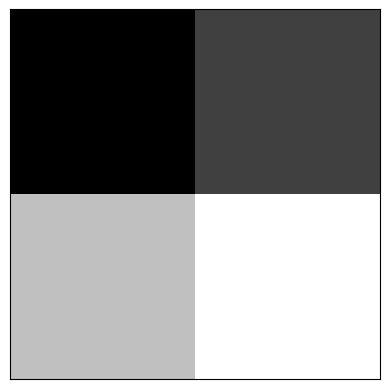

In [3]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
filtered = conv2d(X, K)

# plt.imshow(filtered.numpy(), cmap='gray')
tensor_to_image(filtered)

     0    1    2    3    4    5    6    7
0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0
1  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0
2  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0
3  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0
4  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0
5  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0
 shape -> torch.Size([6, 8])


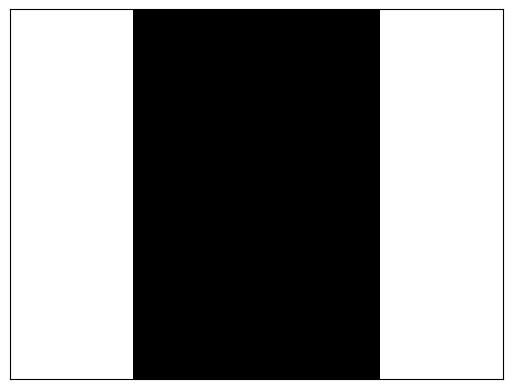

In [4]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
tensor_to_image(X)
print(pd.DataFrame(X.numpy()))
print(f" shape -> {X.shape}")

     0    1
0  1.0 -1.0
1  1.0 -1.0
 shape -> torch.Size([2, 2])


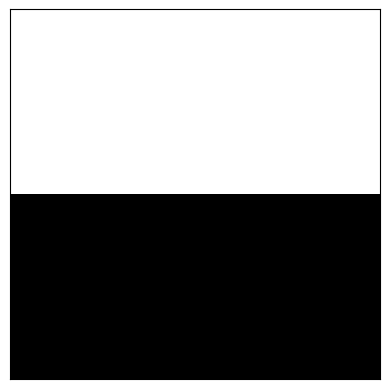

In [5]:
kernel = torch.tensor([[1.0, -1.0], [1.0, -1.0]])
tensor_to_image(kernel.t())
print(pd.DataFrame(kernel.numpy()))
print(f" shape -> {kernel.shape}")

     0    1    2    3    4    5    6
0  0.0  2.0  0.0  0.0  0.0 -2.0  0.0
1  0.0  2.0  0.0  0.0  0.0 -2.0  0.0
2  0.0  2.0  0.0  0.0  0.0 -2.0  0.0
3  0.0  2.0  0.0  0.0  0.0 -2.0  0.0
4  0.0  2.0  0.0  0.0  0.0 -2.0  0.0
 shape -> torch.Size([5, 7])


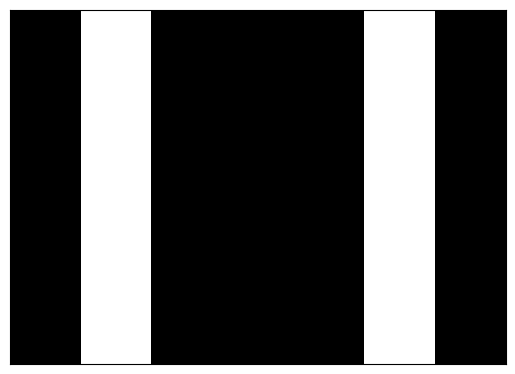

In [6]:
x_filtered = conv2d(X, kernel)
tensor_to_image(x_filtered ** 2)
print(pd.DataFrame(x_filtered.numpy()))
print(f" shape -> {x_filtered.shape}")

 shape -> torch.Size([300, 400])


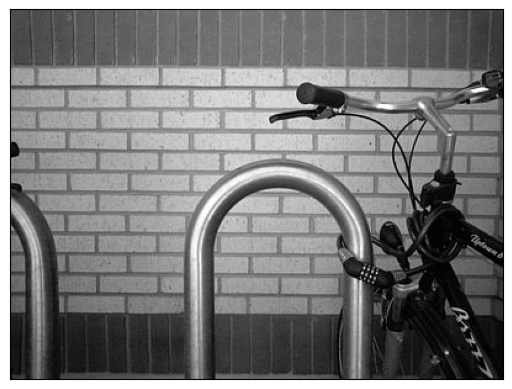

In [7]:
import urllib.request
from PIL import Image

urllib.request.urlretrieve(
  'https://upload.wikimedia.org/wikipedia/commons/thumb/3/3f/Bikesgray.jpg/400px-Bikesgray.jpg',
   "bike.jpg")

im = np.array(Image.open('bike.jpg').convert('L'))
im_tens = torch.Tensor(im)
tensor_to_image(im_tens)
print(f" shape -> {im_tens.shape}")


### We take our vertical kernel and convolve it through the image.

### We take the horizontal kernel and convolve it over the image

In [8]:
vertical_res = conv2d(im_tens, kernel)
horizontal_res = conv2d(im_tens, kernel.t())

shape -> torch.Size([299, 399])


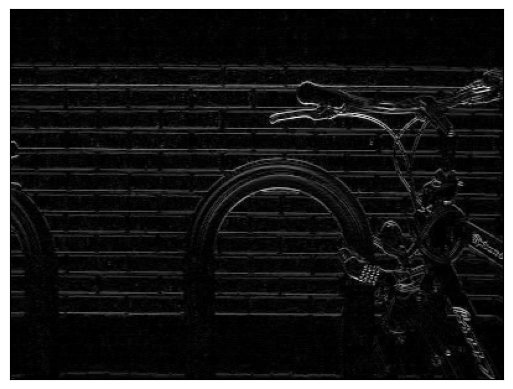

In [9]:
print(f"shape -> {vertical_res.shape}")
tensor_to_image(horizontal_res.abs())

shape -> torch.Size([299, 399])


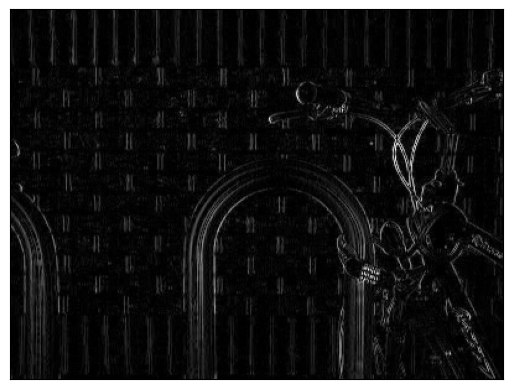

In [10]:
tensor_to_image(vertical_res.abs())
print(f"shape -> {vertical_res.shape}")

shape -> torch.Size([299, 399])


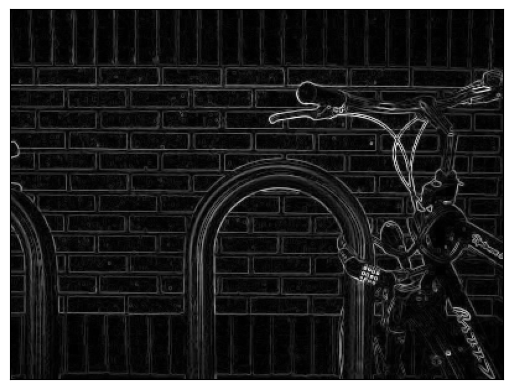

In [11]:
c = (horizontal_res ** 2 + vertical_res ** 2) ** 0.5
tensor_to_image(c)
print(f"shape -> {c.shape}")

In [12]:
sobel_hor = torch.Tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_ver = sobel_hor.t()

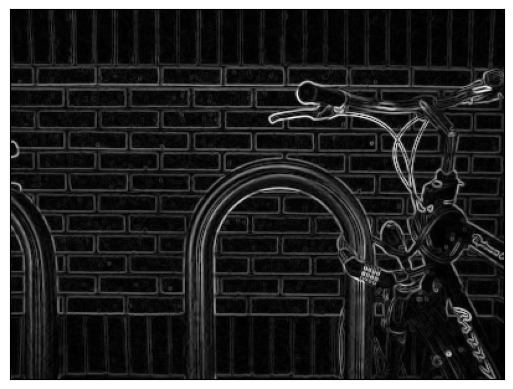

In [13]:
sob_engine_h = conv2d(im_tens, sobel_hor)
sob_engine_v = conv2d(im_tens, sobel_ver)

total_sobel_img = (sob_engine_h ** 2 + sob_engine_v ** 2) ** 0.5
tensor_to_image(total_sobel_img)

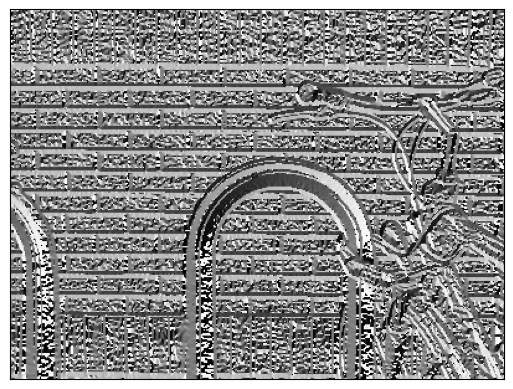

In [14]:
# Sobel operator gradient directions
total_sobel_grad = torch.atan2(sob_engine_v, sob_engine_h)
tensor_to_image(total_sobel_grad)

In [15]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        # Kernel values
        self.weight = nn.Parameter(torch.rand(kernel_size))
        # Bias
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return conv2d(x, self.weight) + self.bias

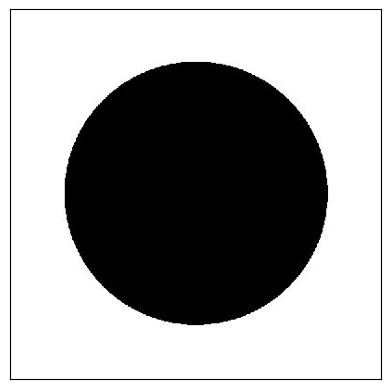

In [16]:
urllib.request.urlretrieve(
  'https://upload.wikimedia.org/wikipedia/commons/6/61/Black_Circle.jpg',
   "circle.jpg")

circle_im = torch.Tensor(np.array(Image.open('circle.jpg').convert('L')))
tensor_to_image(circle_im)



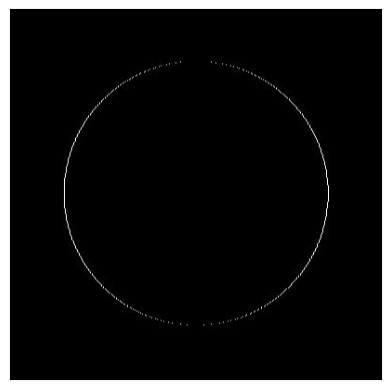

In [17]:
filtered_circle = conv2d(circle_im, kernel)
tensor_to_image(filtered_circle.abs())

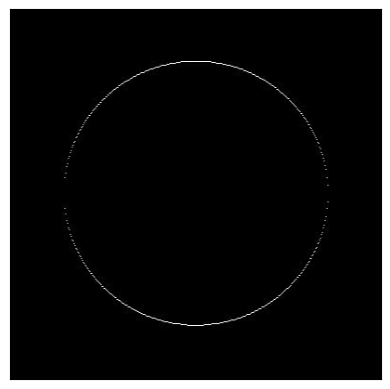

In [18]:
filtered_circle_t = conv2d(circle_im, kernel.t())
tensor_to_image(filtered_circle_t.abs())

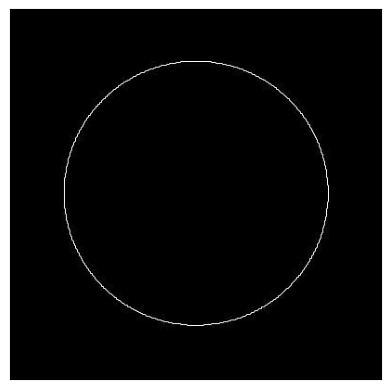

In [19]:
tensor_to_image((filtered_circle_t ** 2 + filtered_circle ** 2) ** 0.5)

In [20]:
conv_nn = Conv2D((2,2))

# Imput image from the previous example
X = torch.ones((6, 8))
X[:, 2:6] = 0

# Predesigned kernel from the previous example
Y = conv2d(X, kernel)

lr = 3e-2  # Learning rate

for i in range(300):
    Y_hat = conv_nn(X)
    l = (Y_hat - Y)**2
    conv_nn.zero_grad()
    l.mean().backward()
    # Update the kernel
    conv_nn.weight.data[:] -= lr * conv_nn.weight.grad
    if (i + 1) % 20 == 0:
        print(f'iteration {i + 1}, loss {l.mean():.3f}')

iteration 20, loss 0.979
iteration 40, loss 0.459
iteration 60, loss 0.229
iteration 80, loss 0.115
iteration 100, loss 0.057
iteration 120, loss 0.029
iteration 140, loss 0.014
iteration 160, loss 0.007
iteration 180, loss 0.004
iteration 200, loss 0.002
iteration 220, loss 0.001
iteration 240, loss 0.000
iteration 260, loss 0.000
iteration 280, loss 0.000
iteration 300, loss 0.000


In [21]:
conv_nn.weight

Parameter containing:
tensor([[ 1.1511, -1.0197],
        [ 0.8351, -0.9665]], requires_grad=True)

In [22]:
kernel

tensor([[ 1., -1.],
        [ 1., -1.]])

# Padding

In [23]:
from torch.nn import functional as F

shape -> torch.Size([399, 400])


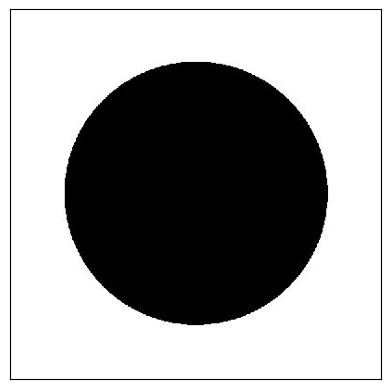

In [24]:
circle_im = torch.Tensor(np.array(Image.open('circle.jpg').convert('L')))
print(f"shape -> {circle_im.shape}")
tensor_to_image(circle_im)

shape -> torch.Size([401, 402])


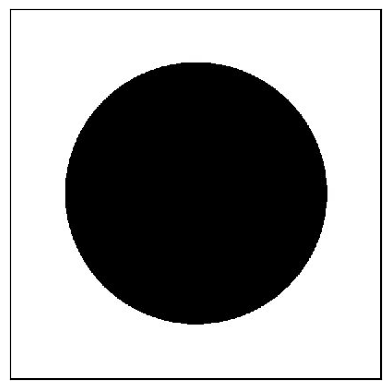

In [25]:
padded_circle_im = F.pad(circle_im, (1,1,1,1), value=1)
print(f"shape -> {padded_circle_im.shape}")
tensor_to_image(padded_circle_im)

shape -> torch.Size([399, 400])


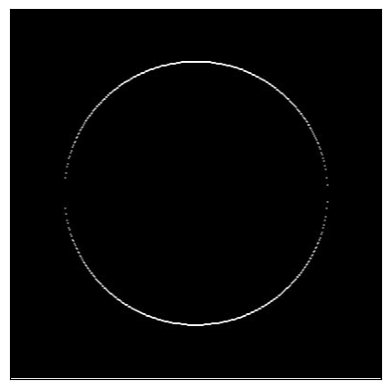

In [26]:
f_circle_im = conv2d(padded_circle_im, sobel_ver)
print(f"shape -> {f_circle_im.shape}")
tensor_to_image(f_circle_im.abs())

# Convolutional Neural Networks

## Import all libs

In [27]:
import numpy as np # to handle matrix and data operation
import pandas as pd # to read csv and handle dataframe

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import optim

from sklearn.model_selection import train_test_split

## Download MNIST

In [28]:
data = datasets.MNIST(
    root = 'data/mnist',
    train = True,
    transform = ToTensor(),
    download = True,
)
test_data = datasets.MNIST(
    root = 'data/mnist',
    train = False,
    transform = ToTensor()
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5124137.11it/s]


Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 133874.97it/s]


Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1269219.62it/s]


Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5285940.28it/s]

Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



In [29]:
len(data)

60000

## Let's quickly inspect the data

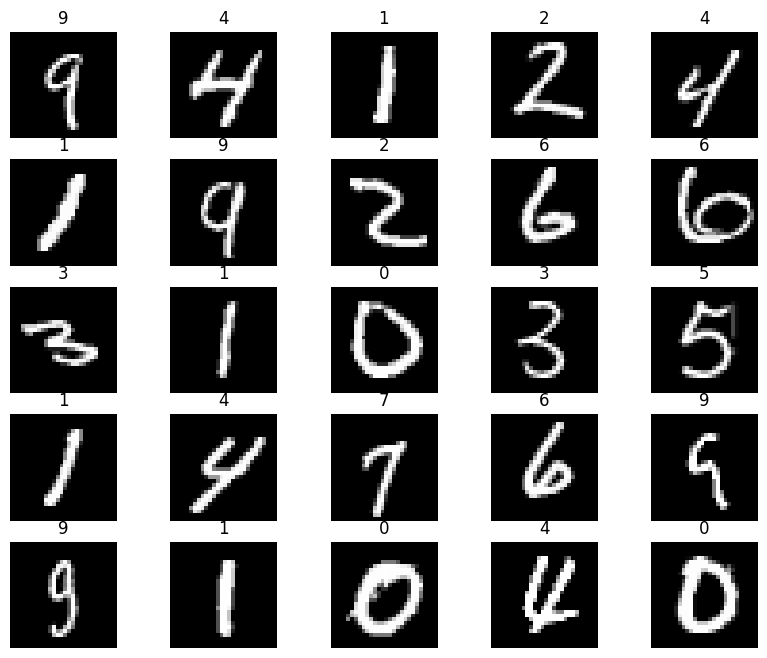

In [30]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(data), size=(1,)).item()
    img, label = data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Let's split the data into training and validation like the last time

In [31]:
train_set, val_set = torch.utils.data.random_split(data, [50000, 10000])

## Dataloader helps us sample a mini_batch
Mini-batches are a way to train an epoch on a smaller random sample of the training data to avoid overfitting and improve the performance with large datasets.

In [32]:
from torch.utils.data import DataLoader

loaders = {
    'train' : torch.utils.data.DataLoader(train_set,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),

    'validation'  : torch.utils.data.DataLoader(val_set,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),
    'test'  : torch.utils.data.DataLoader(test_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),
}

## Now it's time to design a Convolutional Neural Network

Parameters

**in_channels (int)** — Number of channels in the input image

**out_channels (int)** — Number of channels produced by the convolution

**kernel_size (int or tuple)** — Size of the convolving kernel

**stride (int or tuple, optional)** — Stride of the convolution. Default: 1

**padding (int or tuple, optional)** — Zero-padding added to both sides of the input. Default: 0

**padding_mode (string, optional)** — ‘zeros’, ‘reflect’, ‘replicate’ or ‘circular’.
Default: ‘zeros’

**groups (int, optional)** — Number of blocked connections from input channels to output channels. Default: 1

**bias (bool, optional)** — If True, adds a learnable bias to the output. Default: True

In [33]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output 10 classes
        self.fully_connected = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        output = self.fully_connected(x)
        return output    # return x for visualization

## We can get overall info on the network we just created

In [34]:
conv_nn = CNN()
print(conv_nn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fully_connected): Linear(in_features=1568, out_features=10, bias=True)
)


## Loss function and optimizer

Now we define the loss function. We coose cross entropy since we want a categorical output.
We also choose an optimizer. Optimizer is the algorithm that changes the weights depending on the loss function gradient dependent on the NN parameters. We take Adam since it's better than SGD.

In [35]:
loss_f = nn.CrossEntropyLoss()
optimizer = optim.Adam(conv_nn.parameters(), lr=0.01)
conv_nn.parameters()
for parameter in conv_nn.parameters():
    print(parameter.shape)


torch.Size([16, 1, 5, 5])
torch.Size([16])
torch.Size([32, 16, 5, 5])
torch.Size([32])
torch.Size([10, 1568])
torch.Size([10])


## Now we make a loop where we train the network

In [36]:

def train(num_epochs, nn, loaders):
  min_valid_loss = np.inf

  if torch.cuda.is_available():
    nn.cuda()

  for epoch in range(num_epochs):

    # Train the model
    epoch_train_loss = 0
    # This line tells our NN that it's in the training mode
    # This will become relevant when we introduce layers that behave
    # differently in training and deployment/evaluation modes
    nn.train()
    for i, (images, labels) in enumerate(loaders['train']):
      if torch.cuda.is_available():
        images, labels = images.cuda(), labels.cuda()
      output = nn(images)
      loss = loss_f(output, labels)
      epoch_train_loss += loss.item()

      # clear gradients for this training step
      optimizer.zero_grad()

      # backpropagation, compute gradients
      loss.backward()
      # apply gradients
      optimizer.step()

    # Validate the model
    epoch_val_loss = 0
    nn.eval()
    for images_v, labels_v in loaders['validation']:
      if torch.cuda.is_available():
        images_v, labels_v = images_v.cuda(), labels_v.cuda()
      output = nn(images_v)
      loss_v = loss_f(output, labels_v)
      epoch_val_loss += loss_v.item()

    print(f'Epoch {epoch+1}')
    print(f'Training Loss: {epoch_train_loss / len(loaders["train"])}')
    print(f'Validation Loss: {epoch_val_loss / len(loaders["validation"])}')
    print('-------------------')
    if min_valid_loss > epoch_val_loss:
      print(f'Validation Loss Decreased({min_valid_loss}--->{epoch_val_loss}) \t Saving The Model')
      min_valid_loss = epoch_val_loss
      # Saving State Dict
      torch.save(nn.state_dict(), 'saved_model.pth')

train(10, conv_nn, loaders)

Epoch 1
Training Loss: 0.17781419176608323
Validation Loss: 0.058617962850257756
-------------------
Validation Loss Decreased(inf--->5.861796285025775) 	 Saving The Model
Epoch 2
Training Loss: 0.06303774550976232
Validation Loss: 0.04476806136313826
-------------------
Validation Loss Decreased(5.861796285025775--->4.476806136313826) 	 Saving The Model
Epoch 3
Training Loss: 0.050027105099987236
Validation Loss: 0.05043274261988699
-------------------
Epoch 4
Training Loss: 0.047768161765648985
Validation Loss: 0.04662897950154729
-------------------
Epoch 5
Training Loss: 0.042853598888847044
Validation Loss: 0.06628084499505349
-------------------
Epoch 6
Training Loss: 0.045454208954819476
Validation Loss: 0.05470441442157607
-------------------
Epoch 7
Training Loss: 0.0430354045543354
Validation Loss: 0.06923392180586234
-------------------
Epoch 8
Training Loss: 0.04024861572874943
Validation Loss: 0.07443887660396285
-------------------
Epoch 9
Training Loss: 0.034216875142359

In [37]:
def evaluate(model, test_loader):
  if torch.cuda.is_available():
    model.cuda()
  model.eval()
  correct = 0
  for test_imgs, test_labels in test_loader:
    if torch.cuda.is_available():
      test_imgs, test_labels = test_imgs.cuda(), test_labels.cuda()
    output = model(test_imgs)
    predicted = torch.max(output,1)[1]
    correct += (predicted == test_labels).sum()
  print("Test accuracy:{:.3f} ".format( float(correct) / (len(test_loader)*100)))

In [38]:
saved_nn = CNN()
saved_nn.load_state_dict(torch.load('saved_model.pth'))
evaluate(saved_nn, loaders['test'])

Test accuracy:0.985 
